#  Keras  2. Свёрточные нейронные сети

## Введение

* Каждый слой полносвязной сети - это переход в новое пространство признаков (features).
<img src="cnn_xor.png" style="width:600px"> 

<img src="cnn_n1.png" style="width:75px; float:left; margin-right:20px;"> 
<img src="cnn_n2.png" style="width:75px;  float:right; margin-left:10px;"> 
* Глубокие сети (много слоёв) имеют очень много параметров и затухающий градиент (медленно учатся).
* Прореживание связей.
* Прореживание с едиными весами.

## Свёрточный слой

* `Conv1D` - одномерная цепочка нейронов на входе и входе
* `Conv2D` - двумерный массив нейронов на входе и входе ("картинка")


### Kernal (ядро)

<img src="cnn_IxK.png" style="width:350px; float:left; margin-right:20px;"> 
<img src="cnn_Sy.png" style="width:350px;  float:right; margin-left:10px;"> 

Для `Conv2D` часто используют `(3,3)` или `(5,5)`. Но квадратным быть не обязан.

`model.add( Conv2D(1, (3, 3) )`<br> 
свёрточный слой с одним фильтром (ядром) размера 3x3

### Stride (сдвиг)

<img src="cnn_strides.png" style="width:400px; float:left; margin-right:50px;"> 
Для ширины входа $W$ и ядра $K$ при шаге $S$ ширина выхода равна:
$$
O = \frac{W-K}{S} + 1
$$
Если padding (см.ниже) не используется размер выхода меньше чем входа. При `strides=1` (по умолчанию) ширина выхода равна $W-K+1$.

### Padding (подкладка)

<img src="cnn_padding.png" style="width:300px; float:left; margin-right:50px;">
В keras padding = `"valid"` или `"same"`.<br> В первом случае результат свёртки будет меньше. 

Если `stride=1` и `padding="same"`, то выход равен входу.<br> Ячейки ядра, выходящие за вход, "умножаются" на  нули.

### Dilation rate (расширение)

<img src="cnn_dilated.png" style="width:500px; float:left; margin-right:50px;">

## Лапласиан и градиент изображения

Загрузим изображение при помощи библиотеки `skimage` и вычисли его вертикальный градиент оператором Собеля.

(325, 256)


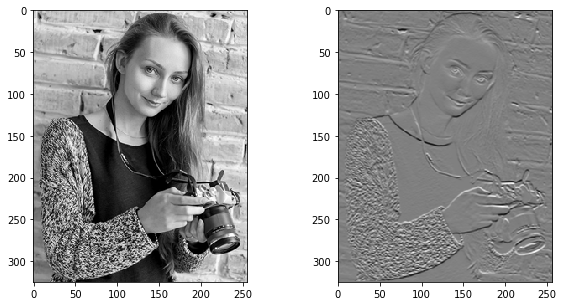

In [2]:
import numpy as np                           # работа с массивами
import matplotlib.pyplot as plt              # постороение графиков
from   skimage import io                     # загрузка файлов
from   skimage import filters                # графические фильтры

img  = io.imread('cnn_Dasha.png')            # загружаем картинку как np-массив

print(img.shape)
img_h, img_w = img.shape                     # высота и ширина картинки

sob_h= filters.sobel_h(img)                  # и вертикальный градиент

plt.subplots(1,2, figsize=(10, 5) );         # 1-а строка с 3-я картинками 
plt.subplot (1, 2, 1);  plt.imshow(img,   cmap=plt.cm.gray)  # исходное изображение
plt.subplot (1, 2, 2);  plt.imshow(sob_h,cmap=plt.cm.gray)   # вертикальный градиент
plt.show()

## Свёрточный слой

Создадим сеть из одного свёрточного слоя (размерность выхода рава размерности входа). Ядро 3x3

In [4]:
from   keras.models  import Sequential                # стопка слоёв
from   keras.layers  import Conv2D, MaxPooling2D      # типы слоёв
from   keras         import backend as K              
K.clear_session()                                     # очищаем имена слоёв

model = Sequential()                                  # "стопка" из одного слоя:
model.add(Conv2D(1, (3, 3), padding   = "same",       # выход равен входу
                 input_shape=(img_h, img_w, 1)))      # размерность входа

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 325, 256, 1)       10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


# Задаём фильтр свёртки

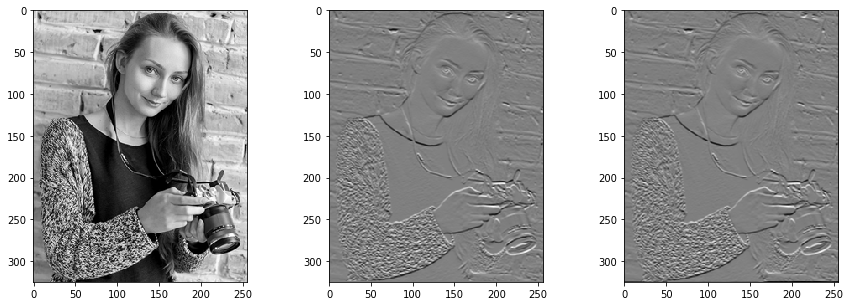

(325, 256) -> (1, 325, 256, 1) -> (1, 325, 256, 1)


In [9]:
b = np.array([0])                   # смещения
w = np.array(                       # веса (оператор Собеля)
    [[-1, -2, -1],
     [ 0,  0,  0],
     [ 1,  2,  1]])
w = w.reshape(3, 3, 1, 1)           # к внутреннему представлению

layer = model.get_layer('conv2d_1') # слой с именем conv2d_1
layer.set_weights([w,b])            # задаём веса

inp = img.reshape(1, img_h,img_w,1) # одна картинка в массив входных картинок
out = model.predict( inp )          # вычисляем выход

plt.subplots(1,3, figsize=(15, 5) );          
plt.subplot (1, 3, 1);  plt.imshow(img,         cmap=plt.cm.gray)                   
plt.subplot (1, 3, 2);  plt.imshow(sob_h,       cmap=plt.cm.gray)     
plt.subplot (1, 3, 3);  plt.imshow(out[0,:,:,0],cmap=plt.cm.gray)
plt.show()
print(img.shape,"->",inp.shape,"->",out.shape)

## Слой пулинга

<img src="cnn_max_pool.png" style="width:300px; float:left; margin-right:50px;">

* Добавляет трансляционной инвариантности
* Уменьшает число параметров модели
* По умолчанию шан равен окну пулинга

* `MaxPooling1D    (pool_size=2,      strides=None, padding='valid')`
* `MaxPooling2D    (pool_size=(2, 2), strides=None, padding='valid', data_format=None)`
* `AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)`

In [13]:
K.clear_session()
model = Sequential()

model.add(MaxPooling2D(pool_size=(4, 4), padding  = "same",   # выход равен входу
                       strides  = 4,                          # шаг маски
                       input_shape=(img_h, img_w, 1)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_1 (MaxPooling2 (None, 82, 64, 1)         0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


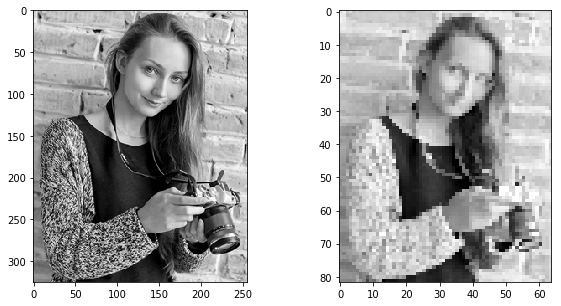

In [14]:
inp = img.reshape(img_h, img_w, 1)           # одноканальная
out = model.predict( np.array([inp]) )

plt.subplots(1,2, figsize=(10, 5) );          
plt.subplot (1, 2, 1);  plt.imshow(img,         cmap=plt.cm.gray)
plt.subplot (1, 2, 2);  plt.imshow(out[0,:,:,0],cmap=plt.cm.gray)
plt.show()

## Карты признаков

В общем случае фильтр не 2-мерный, а 3-мерный.

<img src="cnn_filters.png" width=500>

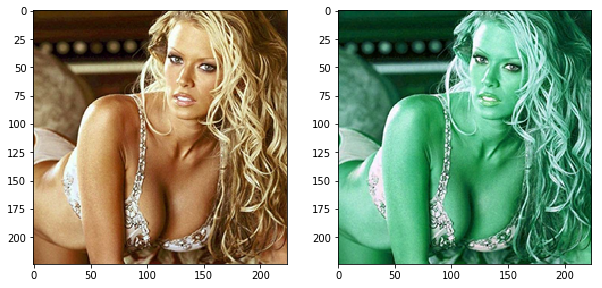

(224, 224, 3) -> (1, 224, 224, 3)
[53 41 15] -> [15 53 41]


In [17]:
im  = io.imread('cnn_woman.png')[:,:,:3]    # загружаем RGB каналы картинки
im_h, im_w, im_d = im.shape                 # высота, ширина и "глубина" картинки

K.clear_session()
model = Sequential()
model.add(Conv2D(3, (1, 1), padding   = "same",       # выход равен входу
                 input_shape=(im_h, im_w, im_d)))

b = np.array(   [0,0,0]  )                      # смещения
w = np.array( [ [0,1,0], [0,0,1], [1,0,0] ] )   # веса
w = w.reshape(1, 1, 3, 3)                       # к внутреннему представлению

layer = model.get_layer('conv2d_1')             # слой с именем conv2d_1
layer.set_weights([w,b])                        # задаём веса

inp = im.reshape(1,im_h, im_w, im_d)
out = model.predict( inp )                      # получаем выход
out = out.astype(int)                           # float -> int

plt.subplots(1,2, figsize=(10, 5) );            # выводим вход и выход
plt.subplot (1, 2, 1);  plt.imshow(im)                   
plt.subplot (1, 2, 2);  plt.imshow(out[0,:,:])
plt.show()
print(im.shape,"->",out.shape)
print(inp[0,0,0,:],"->" ,out[0,0,0,:])

Пример: сеть VGG-16:

<img src="cnn_vgg16.png" width=600>

# Учим CNN геометрии 
## Возьмём 3 класса

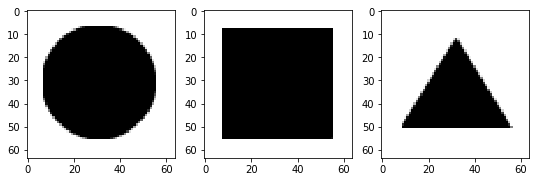

(64, 64, 1)
(1, 64, 64, 1)


In [19]:
from keras.preprocessing.image import load_img, array_to_img, img_to_array

fnames = ["circle/circle_01", "quad/quad_01", "tri/tri_01"]
plt.subplots(1,3, figsize=(9, 3) ); ind = 1
for fname in fnames:
    img = load_img("geom/"+fname+".png",  grayscale=True,  target_size=(64, 64))
    plt.subplot (1, 3, ind);  ind += 1
    plt.imshow(img, cmap='gray')        
plt.show()

x_img = img_to_array(img)                  # this is a Numpy array  (3, 128, 128)
print(x_img.shape)

x_img = x_img.reshape((1,) + x_img.shape)  # this is a Numpy array (1, 3, 128, 128)
print(x_img.shape)


## Генерация случайных деформаций¶
### Использование стандартного генератора

In [20]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(                
        #rescale=1./255,          # нормирвка пикселей к [0...1] !!!
        zoom_range    = [1, 2],   # Range for zoom
        rotation_range= 90,       # Degree range for rotations          
        width_shift_range =0.5,   # Range for horizontal shifts (fraction of total width)
        height_shift_range=0.5,   # Range for vertical   shifts (fraction of total height)
        shear_range=0,            # Shear mapping (скос)        
        fill_mode='constant',
        cval=255)

i = 0
for batch in datagen.flow(x_img, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='png'):
    i += 1
    if i > 20:
        break 

### Переопределение генератора
Переопределим функцию деформации картинок, чтобы не было искажений (в коде ImageDataGenerator перепутан порядок матриц преобразований)

In [21]:
from keras.preprocessing.image import ImageDataGenerator
import scipy.ndimage as ndi

def shift_mat(dx,dy):                 # матрица сдвига
    return np.array([[1, 0, dx], 
                     [0, 1, dy],  
                     [0, 0, 1]])
def zoom_mat(zx,zy):                  # матрица масштабирования:
    return np.array([[zx, 0, 0],
                     [0, zy, 0],
                     [0,  0, 1]])
def rot_mat(angle):                   # матрица поворота: 
    return np.array([[np.cos(angle), -np.sin(angle), 0],
                     [np.sin(angle),  np.cos(angle), 0],
                     [0, 0, 1]])

def transform(mat, x, channel_axis):  # преобразуем картинку x матрицей mat           
    x = np.rollaxis(x, channel_axis, 0)
    channel_images = [ndi.interpolation.affine_transform(x_channel,
                           mat[:2, :2], mat[:2, 2],  
                           order=1, mode='constant',cval=255) 
                      for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x

def random_transform(self, x, seed=None):        
    zx = zy  = np.random.uniform(1, 4)
    angle    =   np.deg2rad(np.random.uniform(-90, 90))
    sx, sy  = np.random.uniform(-28, 28, 2)
    
    mat = np.dot(np.dot(zoom_mat(zx,zy), rot_mat(angle)), shift_mat(sx,sy))    
     
    # Переводим преобразование относительно центра картинки:
    o_x = float(x.shape[self.row_axis-1]) / 2 + 0.5
    o_y = float(x.shape[self.col_axis-1]) / 2 + 0.5
    mat =  np.dot(np.dot(shift_mat(o_x, o_y), mat), shift_mat(-o_x, -o_y))
        
    return transform(mat, x, self.channel_axis-1)    

ImageDataGenerator.random_transform = random_transform # меняем метод

### Тестирование генератора

In [ ]:
img = load_img("geom/tri/tri_01.png",  grayscale=True,  target_size=(64, 64))
x_img = img_to_array(img)              
x_img = x_img.reshape((1,) + x_img.shape)

datagen = ImageDataGenerator()

i = 0
for batch in datagen.flow(x_img, batch_size=1,
                          save_to_dir='preview', save_prefix='tri', save_format='png'):
    i += 1
    if i > 100:
        break  

## Определяем архитектуру сети

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras        import backend as K   # доступ к настройкам
K.clear_session()                       # сброс номеров имён слоёв

img_h, img_w = (64,64)                  # размеры картинок

model = Sequential()
model.add(Conv2D(16, (7, 7), input_shape=(img_h, img_w, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(8, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(4, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten()) 
model.add(Dense(64))
model.add(Activation('relu'))
#model.add(Dropout(0.25))
model.add(Dense(3))
model.add(Activation('softmax'))

model.summary()

In [39]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras        import backend as K   # доступ к настройкам
K.clear_session()                       # сброс номеров имён слоёв

img_h, img_w = (64,64)                  # размеры картинок

model = Sequential()
model.add(Conv2D(36, (5, 5), input_shape=(img_h, img_w, 1)))
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(60, 60)))

model.add(Flatten()) 
model.add(Dense(50))
model.add(Activation('relu'))
#model.add(Dropout(0.25))
model.add(Dense(10))
model.add(Activation('relu'))
model.add(Dense(3))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 60, 60, 36)        936       
_________________________________________________________________
activation_1 (Activation)    (None, 60, 60, 36)        0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 1, 36)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 36)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1850      
_________________________________________________________________
activation_2 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
__________

### Задаём потоковые генераторы картинок

In [40]:
from keras.preprocessing.image import ImageDataGenerator

batch_size   = 100
img_h, img_w = (64,64)                  # размеры картинок

datagen = ImageDataGenerator(rescale=1./255) # нормирвка пикселей к [0...1]

generator = datagen.flow_from_directory(
        'geom',                      # this is the target directory   
        color_mode="grayscale",
        target_size=(img_h, img_w),  # all images will be resized 
        batch_size=batch_size,
        class_mode='categorical') 

Found 3 images belonging to 3 classes.


### Запускаем обучение
* Если мы сохраняем лучшую модель (`ModelCheckpoint`), то число шагов в эпохе должно быть побольше, чтобы была статистическая значимость для параметра сохранения. Иначе лучшая модель может оказаться не лучшей.
* При увеличении `batch_size` (выше) на GPU происходит ускорение обучения. Однако в этом случае, возможно, надо увеличить скорость обучения.

In [ ]:
%%time
from keras.models     import load_model
from keras.optimizers import SGD, RMSprop, Adadelta, Adam, Adamax, Nadam
from keras.callbacks  import ModelCheckpoint

#%time model = load_model("geom_model.h5")   # загружаем сеть из файла
model.summary()

model.compile(loss='categorical_crossentropy',
              #optimizer=Adam(),
              optimizer=RMSprop(),
              metrics=['accuracy'])

model.fit_generator(
        generator,
        steps_per_epoch=100000 // batch_size,
        epochs=1000,
        callbacks=[ModelCheckpoint("geom_model.h5",      # имя файла
                                   monitor='acc',    # за чем следим
                                   verbose=1, save_best_only=True)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 60, 60, 36)        936       
_________________________________________________________________
activation_1 (Activation)    (None, 60, 60, 36)        0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 1, 36)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 36)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1850      
_________________________________________________________________
activation_2 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
__________

## Тестируем
Используем `evaluate_generator`:

In [33]:
#%time model = load_model("geom_12C5_P4_9D_3D.h5")   # загружаем сеть из файла

%time score = model.evaluate_generator(generator, steps=1000)
print('\nloss: %.4f, acc: %.4f' % (score[0], score[1]) )

Wall time: 1min 41s

loss: 0.0299, acc: 0.9963


Выводим несколько примеров:

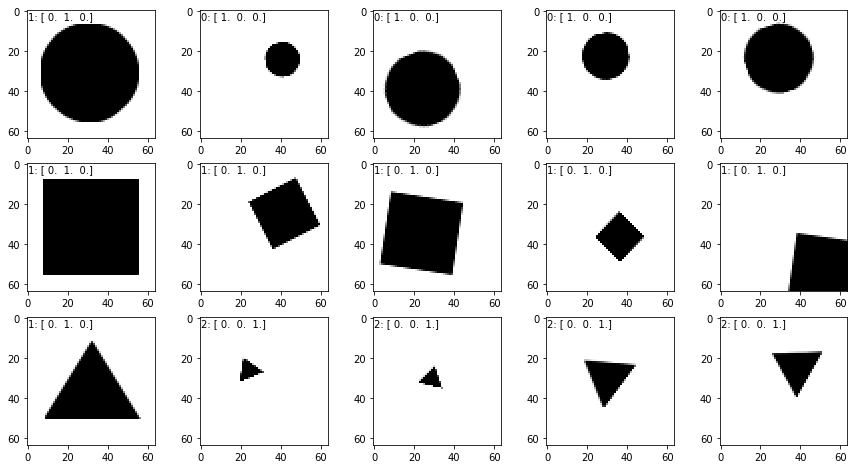

In [34]:
from keras.models        import load_model
from keras.preprocessing import image

np.set_printoptions(precision=3, suppress=True)

#%time model = load_model("geom_32C5_P4_18C3_P2_90D_3D.h5")           # загружаем сеть из файла

import os
dir_name = "geom_samples"
fnames = os.listdir(dir_name)                  # получаем все файлы из директории

plt.subplots(3,5, figsize=(15, 8) ); ind = 1
for fname in fnames:   
    img = image.load_img(dir_name+'/'+fname, grayscale=True, target_size=(img_h, img_w))
    x = image.img_to_array(img)    
    x = np.expand_dims(x, axis=0)
    x = x / 255                                # нормирвка пикселей к [0...1] !!!
    preds = model.predict(x)
    info = str(np.argmax(preds)) +": " + str(preds[0,:])
    
    plt.subplot (3, 5, ind);  ind += 1
    plt.imshow(img)                   
    plt.text(0, 4, info)
plt.show()


Выводим только ошибочные картинки из файлов, подготовленных генератором

3 3 1


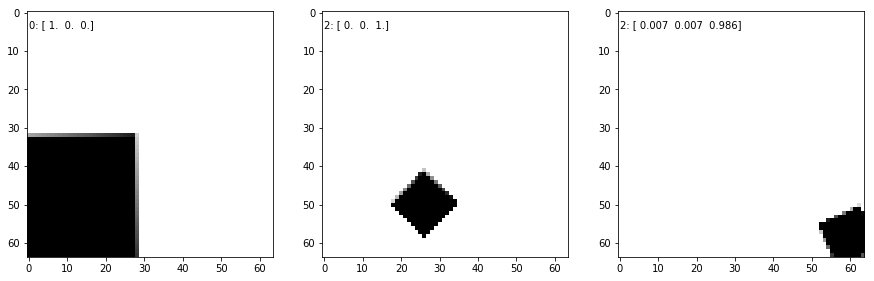

Wall time: 630 ms


In [37]:
%%time
from keras.models        import load_model
from keras.preprocessing import image
np.set_printoptions(precision=3, suppress=True)

#%time model = load_model("geom_model3.h5")     # загружаем сеть из файла

import os
dir_name = "geom_test/quad"; y_correct=1
fnames = os.listdir(dir_name)                  # получаем все файлы из директории

img_errs = []
inf_errs = []
for fname in fnames:   
    img = image.load_img(dir_name+'/'+fname, grayscale=True, target_size=(img_h, img_w))
    x = image.img_to_array(img)    
    x = np.expand_dims(x, axis=0)
    x = x / 255                               # нормирвка пикселей к [0...1] !!!
    preds = model.predict(x)
    if np.argmax(preds) != y_correct:
        img_errs.append(img)
        inf_errs.append( str(np.argmax(preds)) +": " + str(preds[0,:]) )

if len(img_errs) > 0:
    cols = len(img_errs) % 5; rows = len(img_errs) // cols 
    print(len(img_errs), cols, rows)
    plt.subplots(rows,cols, figsize=(15, rows*8) ); ind = 1
    for img in img_errs:       
        plt.subplot (rows, cols, ind)
        plt.imshow(img)                   
        plt.text(0, 4, inf_errs[ind-1])
        ind += 1
    plt.show()

## Заглянем внутрь сети
### Рисуем веса (фильтры)

In [ ]:
%time model = load_model("geom_8C5_P2_12C3_P2_16C3_P2_90D_3D.h5") 
layers = ['conv2d_1' ]

for lr in layers:
    layer = model.get_layer(lr)
    w = layer.get_weights()[0]   # веса
    b = layer.get_weights()[1]   # смещение    
    num = w.shape[3]
    vMax = max(np.max(w), -np.min(w));  
    
    plt.subplots(1,num, figsize=(20, 4) );
    for i in range(num):        
        plt.subplot(1, num, i+1); plt.xticks([]); plt.yticks([])
        im = w[:,:,0,i]
        plt.imshow(im, vmin=-vMax, vmax=vMax,  cmap=plt.cm.PuOr_r, interpolation='nearest')
    plt.show()    

### Рисуем выходы промежуточных слоёв

In [ ]:
from keras.models import Model

fnames = ["geom/circle/circle_01", "geom/quad/quad_01", "geom/tri/tri_01"]
layers = ['conv2d_1', 'activation_1', 'activation_2']

for fname in fnames:
    for lr in layers:
        layer = model.get_layer(lr)
        m  = Model(inputs=model.input, outputs=layer.output )  
    
        img = image.load_img(fname+".png", grayscale=True, target_size=(img_h, img_w))
        x = image.img_to_array(img)    
        x = np.expand_dims(x, axis=0)        
        output = m.predict(  x / 255 )
        
        print(lr,output.shape,   layer.kernel_size if hasattr(layer, 'kernel_size') else '')
        num = output.shape[3] if output.ndim==4 else 1 
        plt.subplots(1,num, figsize=(20, 4) );
        for i in range(num):
            plt.subplot(1, num, i+1); plt.xticks([]); plt.yticks([])
            if output.ndim==4:
                im = output[0,:,:,i]
            if output.ndim==3:
                im = output[0,:,:]
            if output.ndim==2:
                im = np.array([output[0,:]])
            plt.imshow(im, cmap=plt.cm.gray_r, interpolation='nearest')
        plt.show()

# Различные задачи рапознавания

<img src="Localization.png" style="width:600px"> 

<img src="Detection.png" style="width:600px"> 

# Вспомогательные функции
<a id="plot_losses"></a>

In [ ]:
!pip install -U -q PyDrive

def downloadFileGoogleDisk(fileName):  
  from pydrive.auth  import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab  import auth
  from oauth2client.client import GoogleCredentials

  auth.authenticate_user() # Authenticate and create the PyDrive client. 
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
      
  fileList = drive.ListFile({'q': "title contains '" + fileName + "'"}).GetList()
  #pdb.set_trace()
  for file in fileList:
    fileDrive = drive.CreateFile({'id': file['id']})
    fileDrive.GetContentFile(file['title'])
    print('File ' + fileName + ' downloaded from Google Disc')

# res, src
def downloadFileToGoogleDrive(fileName, path):
  print('Start download file ' + path + ' to Google Drive with name ' + fileName)
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials

  # Authenticate and create the PyDrive client.
  # This only needs to be done once in a notebook.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  # Create & upload a text file.
  uploaded = drive.CreateFile({'title': fileName})
  uploaded.SetContentFile(path)
  uploaded.Upload()
  print('Uploaded file with ID {}'.format(uploaded.get('id')))
    
def unzipFile(fileName, path):
  import zipfile  
  zip_ref = zipfile.ZipFile(fileName, 'r')
  zip_ref.extractall(path)
  zip_ref.close()
  print('File ' + fileName + ' unzipped')
    
    
ZIP_FILE = 'geom.zip'

downloadFileGoogleDisk(ZIP_FILE)
unzipFile(ZIP_FILE, "")

!ls -l -h 

#downloadFileToGoogleDrive(fname, fname)  # переносим на Google Disk !!!!